<a href="https://colab.research.google.com/github/paigeaera5/Sentiment_Analysis/blob/main/model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

**Install Missing Libraries**

In [4]:
!pip install emoji --upgrade
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 4.5 MB/s eta 0:00:00


**Import Necessary Libraries**

In [5]:
import pandas as pd
import numpy as np
import string
import codecs
import emoji
import os
import re


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup

from imblearn.over_sampling import SMOTE

from google.colab import files, userdata
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load Data**

In [6]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [7]:
# Run if first time
if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  print("Upload kaggle.json here")
  files.upload()

if not os.path.isfile('Sentiment140 Dataset.csv'):
  !rm -r ~/.kaggle
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_name = 'kazanova/sentiment140'
  zip_name = dataset_name.split('/')[-1]

  !kaggle datasets download -d {dataset_name}
  !unzip -q ./{zip_name}.zip -d .

Upload kaggle.json here


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 99% 80.0M/80.9M [00:03<00:00, 34.2MB/s]
100% 80.9M/80.9M [00:03<00:00, 25.6MB/s]


# **Data Cleansing**

## *Read CSV file with specified column names*

In [40]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",
                 names = col_names,
                 encoding = "ISO-8859-1")
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## *Keep only target and text*

In [41]:
df.drop("id", axis = 1, inplace = True)
df.drop("date", axis = 1, inplace = True)
df.drop("flag", axis = 1, inplace = True)
df.drop("user", axis = 1, inplace = True)

df.shape

(1600000, 2)

## *Check for missing values*

In [42]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [43]:
# Number of texts for each target (0=negative, 2=neutral, 4=positive)
target_group = df.groupby('target')
target_group.count()

,text
target,
0,800000
4,800000


Database has no neutral data although the description stated it did. So we will treat this dataset as only identifying text as positive or negative sentiments.

## *Update target values*

*   0 = negative
*   1 = positive



In [44]:
df.replace({'target':{4:1}}, inplace = True)

## *Check target distribution*

<Axes: ylabel='text'>

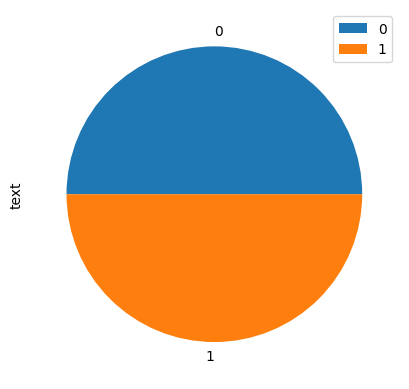

In [45]:
target_group = df.groupby('target')
target_group.count().plot(kind='pie', y='text')

# **Preprocessing**

In [46]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## *Remove URLs and HTMLs*

In [47]:
def remove_urls(text):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(<.*?>))', '', text,
                  flags=re.MULTILINE)

df['text'] = df['text'].apply(remove_urls)
df.head()

,target,text
0,0,"@switchfoot - Awww, that's a bummer. You sho..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## *Remove mentions and hashtags*

In [48]:
def remove_mentions(text):
    return re.sub(r'\@\w+|\#','', text)

df['text'] = df['text'].apply(remove_mentions)
df.head()

,target,text
0,0,"- Awww, that's a bummer. You shoulda got Da..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


## *Remove special characters and whitespace*

In [78]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text.strip()

df['text'] = df['text'].apply(remove_special_characters)
df.head()

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdbcom cool hear old walt interviews
1599997,1,ready mojo makeover ask details
1599998,1,happy 38th birthday boo alll time tupac amaru ...


## *Convert to lowercase*

In [49]:
df['text']=df['text'].str.lower()
df.head()

,target,text
0,0,"- awww, that's a bummer. you shoulda got da..."
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


## *Remove punctuations*

In [50]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuations))

df['text'] = df['text'].apply(remove_punctuation)
df.head()

,target,text
0,0,awww thats a bummer you shoulda got david ...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i he...


## *Remove stopwords from text*

In [52]:
stopwords_list = set(stopwords.words('english'))

In [53]:
# Function to remove stop words
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

df['text'] = df['text'].apply(remove_stopwords)
df.head()

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see


## *Handle emojis*

In [54]:
def remove_emojis(text):
    return emoji.demojize(text)

df['text'] = df['text'].apply(remove_emojis)

df.head()

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see


## *Save cleaned data*

In [79]:
# Save cleaned data
df.to_csv("/content/data/cleaned-data.csv", index=False)

# **Word Cloud Generation**

In [80]:
# Function to generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords_list,
                      min_font_size=10)

## *Positive sentiment*

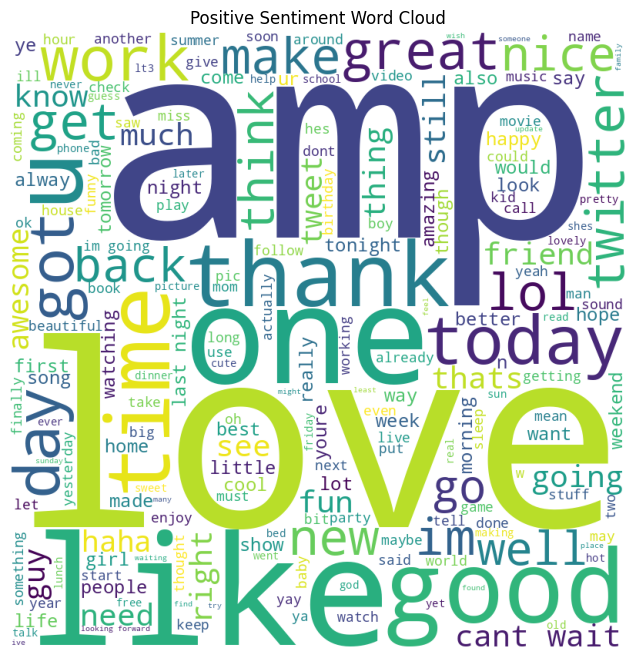

In [81]:
positives = df[df['target'] == 1]
positive_cloud = wordcloud.generate(''.join(positives['text']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_cloud)
plt.axis("off")
plt.title('Positive Sentiment Word Cloud')
plt.show()

## *Negative sentiment*

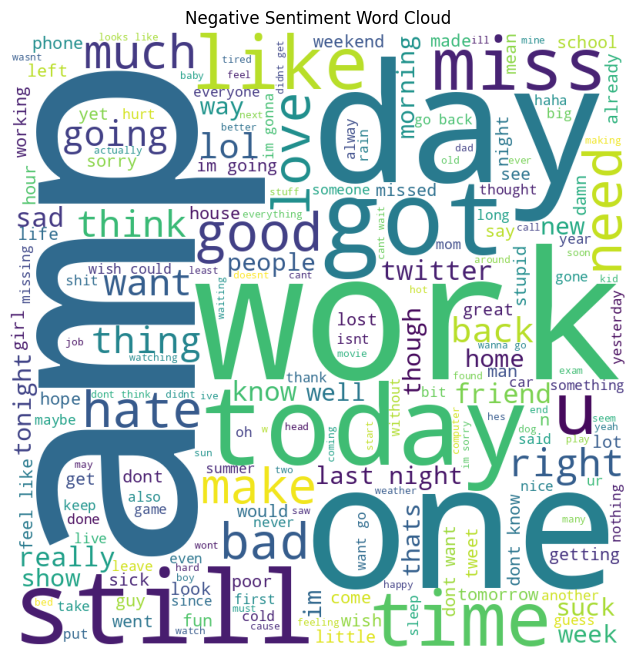

In [82]:
negatives = df[df['target'] == 0]
negative_cloud = wordcloud.generate(''.join(negatives['text']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_cloud)
plt.axis("off")
plt.title('Negative Sentiment Word Cloud')
plt.show()

# **Tokenize and Split Data**

In [83]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)
x = vectorizer.fit_transform(df['text'])
y = df['target']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [84]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [85]:
y_train.value_counts()

target
0    640506
1    639494
Name: count, dtype: int64

In [86]:
vectorizer.get_feature_names_out()
df['text']

0          awww thats bummer shoulda got david carr third...
1          upset cant update facebook texting might cry r...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                   behaving im mad cant see
                                 ...                        
1599995                        woke school best feeling ever
1599996              thewdbcom cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999                                 happy charitytuesday
Name: text, Length: 1600000, dtype: object

# **Model Training and Testing**

In [87]:
# Train a Logistic Regression model
clf = LogisticRegression(
    fit_intercept=True, solver='liblinear'
)
clf.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.77      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.79      0.78    320000



In [66]:
# Train a Logistic Regression model
clf = LogisticRegression(
    fit_intercept=True, solver='liblinear'
)
clf.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

